## Solución Prueba 1. Análisis de Sentimientos de Twitter

**Nombre alumno:** Julio Valdés

**Profesor:** Gabriel Tamayo L.

**Generación:** G5

### Preliminares
#### Descripción del problema y objetivos
* El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si un tweet es positivo o negativo.
* El tipo de problema a resolver es de clasificación.
* El objetivo de este trabajo es desarrollar un modelo predictivo para obtener la probabilidad que un tweet sea positivo o negativo, en base a las palabras que lo forman.

#### Descripción de la solución
* Se realizará un análisis exploratorio sobre los datos contenidos en el dataframe, considerando palabras más comunes y distribución de las clases en el vector objetivo.
* Se realizará el preprocesamiento y luego la representación de cada oración como un conjunto de características.
* Se prepararán el vector objetivo y las matrices de entrenamiento y validación.
* Entrenamiento de modelos
    * Se implementarán cinco modelos distintos reportando las métricas de desempeño con los conjuntos de datos de entrenamiento y validación, analizando la capacidad de generalización de cada uno de ellos.
    * El conjunto de datos de entrenamiento consiste en un 67% y el de validación en un 33% del total de datos.
    * Los modelos serán evaluados de acuerdo a las métricas de presicion, recall y f1-score. Además se hará uso de la curva ROC para complementar la evaluación de estos.
* Se seleccionarán los dos mejores modelos para serializarlos y entregarlos para evaluación

### Aspectos computacionales
#### Descripción de librerías y módulos
Se usarán las siguientes librerías y módulos por cada etapa de la construcción de los modelos:
* ingesta: pandas
* preprocesamiento: pandas, numpy, missingno
* visualización: matplotlib, seaborn
* modelación: statsmodels.api, statsmodels.formula.api, sklearn.preprocessing, sklearn.linear_model, sklearn.model_selection
* métricas de evaluación: sklearn.metrics

### Descripción
#### Se prepara el ambiente de trabajo cargando las librerías necesarias, se importa la BD e imprimen las primeras 5 filas a modo de ejemplo

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = pd.read_csv('training_tweets.csv').drop(columns = ['Unnamed: 0'])
df.head(5)

[nltk_data] Downloading package stopwords to /Users/julio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content,sentiment
0,Happy Mama's day to all mothers,love
1,@LysdelTellez I am lost. Please help me find a...,worry
2,"@BoomKatt yes yes I AM, networking whore to th...",happiness
3,you@snapplynn Wish that would have been your t...,neutral
4,now i am doing the MicroEconomics project iha...,worry


In [41]:
df.describe()

,content,sentiment
count,30000,30000
unique,29881,13
top,I just received a mothers day card from my lov...,neutral
freq,12,6451


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
content      30000 non-null object
sentiment    30000 non-null object
dtypes: object(2)
memory usage: 468.8+ KB


#### Se realiza un análisis exploratorio sobre los datos contenidos en el DataFrame, imprimiendo las 10 palabras más comunes, la distribución de las clases en el vector objetivo y las 5 palabras más comunes por cada sentimiento.
    * Una cantidad importante de los tweets se clasifican como neutrales en sentimiento. Lo sigue en cantidad de tweets worry, happiness y sadness. 
    * La palabra just y day se presentan dentro de las cinco más frecuentes en la mayoría de los sentimientos.
    * La palabra work se encuentra dentro de las cinco más frecuentes en los sentimientos de caracter negativo.

In [43]:
cv = CountVectorizer(stop_words = 'english', max_features= 100)
cv_fit = cv.fit_transform(df['content'])
words = cv.get_feature_names()
words_freq = cv_fit.toarray().sum(axis=0)
pd.DataFrame(words_freq, index = words, columns = ['Cantidad']).sort_values(by=['Cantidad'], ascending=False).head(10)

,Cantidad
day,2403
just,2369
good,1736
like,1444
quot,1399
http,1398
today,1269
love,1245
work,1240
got,1236


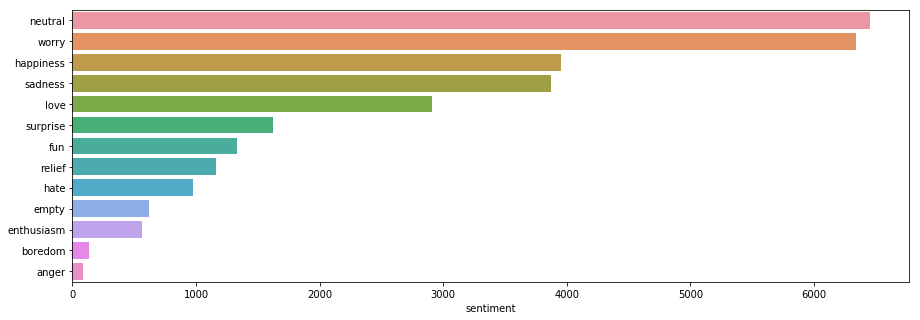

In [44]:
sentiment_count = df['sentiment'].value_counts(ascending = False)
plt.figure(figsize=(15, 5))
sns.barplot(sentiment_count, sentiment_count.index)

In [45]:
def top100(df, sentiment):
    cv = CountVectorizer(stop_words = 'english', max_features= 100)
    cv_fit = cv.fit_transform(df[df['sentiment'] == sentiment]['content'])
    words = cv.get_feature_names()
    words_freq = cv_fit.toarray().sum(axis=0)
    return pd.DataFrame(words_freq, index = words, columns = ['Cantidad']).sort_values(by=['Cantidad'], ascending=False)

In [46]:
for sentiment in sentiment_count.index:
    print("Sentiment: {}".format(sentiment))
    print(top100(df, sentiment).head(5))
    print("---------------------------------")

Sentiment: neutral
      Cantidad
just       436
http       413
day        321
com        311
quot       296
---------------------------------
Sentiment: worry
      Cantidad
just       521
like       344
day        317
don        313
got        304
---------------------------------
Sentiment: happiness
        Cantidad
day          492
good         428
just         324
happy        321
thanks       228
---------------------------------
Sentiment: sadness
      Cantidad
just       299
sad        295
day        271
miss       261
work       243
---------------------------------
Sentiment: love
        Cantidad
love         665
day          592
happy        452
good         243
mother       223
---------------------------------
Sentiment: surprise
      Cantidad
just       161
quot       114
day         95
oh          88
http        83
---------------------------------
Sentiment: fun
      Cantidad
lol        138
just       111
quot        99
fun         99
day         88
---------------

#### Se realiza el preprocesamiento de los datos
    * Se transforman los tweets a lower case
    * Se eliminan URLs y user mentions
    * Generar la exclusión de stopwords mediante libreria nltk
    * Se muestran las 10 palabras con mayor frecuencia

In [47]:
def preprocesamiento(text):
    """
    Preprocesa un texto realizando las siguientes acciones:
        * Se transforma el texto a lower case
        * Se eliminan URL
        * Se eliminan user mentions
    Retorna el texto preprocesado.
    """
    text = text.lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    
    return text

In [48]:
cv = CountVectorizer(stop_words = stopwords.words('english'), max_features= 100, preprocessor=preprocesamiento)
cv_fit = cv.fit_transform(df['content'])
words = cv.get_feature_names()
words_freq = cv_fit.toarray().sum(axis=0)
pd.DataFrame(words_freq, index = words, columns = ['Cantidad']).sort_values(by=['Cantidad'], ascending=False).head(10)

,Cantidad
day,2403
good,1735
get,1503
like,1444
quot,1391
go,1364
today,1269
love,1245
work,1237
got,1235


#### Se realiza el refinamiento de los datos

#### Preparación del vector objetivo y las matrices de entrenamiento y validación
* Se eliminan registros con sentiment igual a neutral
* Se recodifica el vector objetivo para trabajar con emociones positivas o negativas
    * Al recodificar el vector objetivo se observa que las clases se encuentran balanceadas
    * Las palabras con mayor frecuencia son similares en ambos grupos pero en los sentimientos Positivos destacan palabras como 'love' y 'happy', y en los sentimientos Negativos destacan 'work' y 'today'

In [49]:
index = df[df['sentiment'] == 'neutral'].index
df.drop(index, inplace=True)
df['sentiment'] = np.where(df['sentiment'].isin(
    ['happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm']), 'Positiva', df['sentiment'])
df['sentiment'] = np.where(df['sentiment'].isin(
    ['worry', 'sadness', 'hate', 'empty', 'boredom', 'anger']), 'Negativa', df['sentiment'])

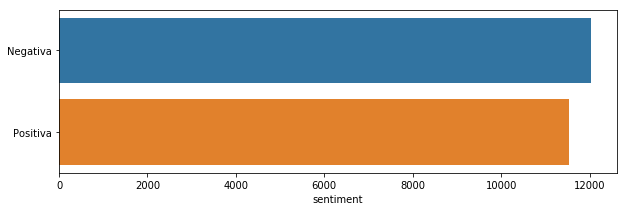

In [53]:
sentiment_count = df['sentiment'].value_counts(ascending = False)
plt.figure(figsize=(10, 3))
sns.barplot(sentiment_count, sentiment_count.index)

In [54]:
for sentiment in sentiment_count.index:
    print("Sentiment: {}".format(sentiment))
    print(top100(df, sentiment).head(5))
    print("---------------------------------")

Sentiment: Negativa
       Cantidad
just        969
day         665
like        647
work        646
today       560
---------------------------------
Sentiment: Positiva
       Cantidad
day        1417
good        975
just        964
love        933
happy       891
---------------------------------


In [57]:
label_encoder = LabelEncoder()
df['sentiment_bin'] = label_encoder.fit_transform(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(df['content'], df['sentiment_bin'], random_state=11238, test_size = 0.33)

#### Entrenamiento de modelos

##### Modelo 1: Multinomial NB

In [58]:
pipeline_model1 = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features= 100, preprocessor=preprocesamiento)), 
    ('multinomial', MultinomialNB())
])
pipeline_model1.fit(X_train, y_train)
y_hat = pipeline_model1.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.64      0.80      0.71      4009
           1       0.71      0.52      0.60      3763

   micro avg       0.66      0.66      0.66      7772
   macro avg       0.67      0.66      0.65      7772
weighted avg       0.67      0.66      0.65      7772



##### Modelo 2: LDA

In [70]:
from sklearn.preprocessing import FunctionTransformer

pipeline_model2 = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features= 100, preprocessor=preprocesamiento)), 
    ('transform', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('lda', LinearDiscriminantAnalysis())
])
pipeline_model2.fit(X_train, y_train)
y_hat2 = pipeline_model2.predict(X_test)
print(classification_report(y_test, y_hat2))

/Users/julio/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.64      0.80      0.71      4009
           1       0.71      0.52      0.60      3763

   micro avg       0.67      0.67      0.67      7772
   macro avg       0.68      0.66      0.66      7772
weighted avg       0.68      0.67      0.66      7772



/Users/julio/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:98: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


##### Modelo 3: SVC

In [76]:
c_param_range = [0.0001, 0.01, 1, 100, 1000]
gamma_param_range = [0.0000001, 0.001, 0.1, 10]
param_grid = dict(gamma = gamma_param_range, C = c_param_range)
grid_search_cv = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features= 100, preprocessor=preprocesamiento)),
    ('grid', GridSearchCV(SVC(), param_grid = param_grid, cv=3))
])
grid_search_cv.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function preprocesamiento at 0...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [77]:
grid_step = grid_search_cv.named_steps['grid']
print("La mejor combinación de hiperparámetros son %s con un desempeño del %0.2f" % (grid_step.best_params_, grid_step.best_score_))

La mejor combinación de hiperparámetros son {'C': 1, 'gamma': 0.1} con un desempeño del 0.65


In [78]:
pipeline_model3 = Pipeline([
    ('cv', CountVectorizer(stop_words = stopwords.words('english'), max_features= 100, preprocessor=preprocesamiento)), 
    ('svc', SVC(kernel='rbf', C=1, gamma=0.01))
])
pipeline_model3.fit(X_train, y_train)
y_hat3 = pipeline_model3.predict(X_test)
print(classification_report(y_test, y_hat3))

              precision    recall  f1-score   support

           0       0.61      0.87      0.72      4009
           1       0.75      0.42      0.54      3763

   micro avg       0.65      0.65      0.65      7772
   macro avg       0.68      0.64      0.63      7772
weighted avg       0.68      0.65      0.63      7772

